In [1]:
from mixture_composition_regression.examples.load_dipa_water_nacl_training_set import load_training_set
from mixture_composition_regression.cross_validation import cv_on_model_and_wavelength
import pandas as pd
from mixture_composition_regression.import_spectrum import clean_data
from mixture_composition_regression.sample import Sample
from mixture_composition_regression.mixture import Mixture

from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression



In [2]:
import matplotlib.pyplot as plt

file = '/Users/ianbillinge/Documents/yiplab/projects/ir/cellulose/all_spectra.csv'
df = clean_data(file)

w_file = '/Users/ianbillinge/Documents/yiplab/projects/ir/cellulose/composition.csv'
composition = pd.read_csv(w_file)
samples = np.array(composition.columns)[1:]

cp = {'name': ['cellulose', 'hemicellulose', 'lignin'],
      'mw': [1, 1, 1],
      'nu': [1, 1, 1]}
ds = []

for s in samples:
    ds.append(Sample(s, df, x_col_name='wavenumber', a_col_name=s, chem_properties=cp, w=list(composition[s]/100.)))

mix = Mixture(ds,)


Checking samples in mixture None


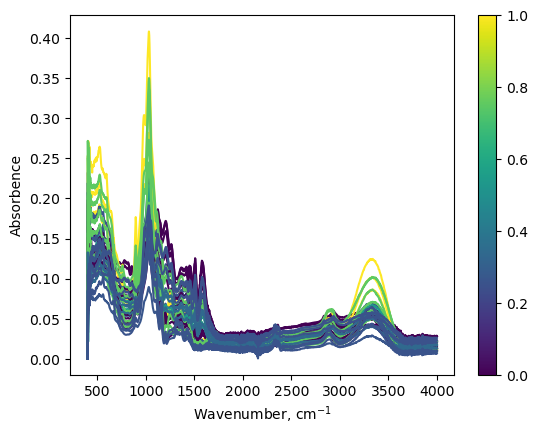

In [10]:
mix.plot_by(savefig='mix', idx=1, xlabel=r'Wavenumber, cm$^{-1}$', ylabel='Absorbence', cmap_name='viridis')

In [13]:
mix.samples[0].da

<xarray.DataArray (name: 1, x: 7469)>
array([[0.        , 0.1931197 , 0.1849076 , ..., 0.02767399, 0.02770538,
        0.02778401]])
Coordinates:
  * x              (x) float64 399.7 400.2 400.6 401.1 ... 3.999e+03 4e+03 4e+03
  * name           (name) <U4 's1t1'
    cellulose      (name) float64 0.0
    hemicellulose  (name) float64 0.0
    lignin         (name) float64 1.0

In [19]:
mix.da.where(mix.da.coords['lignin']>0.5)

<xarray.DataArray (name: 39, x: 7469)>
array([[0.        , 0.1931197 , 0.1849076 , ..., 0.02767399, 0.02770538,
        0.02778401],
       [0.        , 0.1765026 , 0.1783027 , ..., 0.02822588, 0.02826771,
        0.02830986],
       [0.        , 0.1743783 , 0.1766949 , ..., 0.02789727, 0.02793804,
        0.02800985],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * x              (x) float64 399.7 400.2 400.6 401.1 ... 3.999e+03 4e+03 4e+03
  * name           (name) <U5 's1t1' 's1t2' 's1t3' ... 's13t1' 's13t2' 's13t3'
    cellulose      (name) float64 0.0 0.0 0.0 1.0 ... 0.0 0.7426 0.7426 0.7426
    hemicellulose  (name) float64 0.0 0.0 0.0 0.0 ... 0.25 0.2574 0.2574 0.2574
    lignin         (name) float64 1.0 1.0 1.0 0.0 0.0 ... 0.75 0.75 0.0 0.0 0.0

In [ ]:
file = '/Users/ianbillinge/Documents/yiplab/projects/ir/cellulose/all_spectra.csv'
spectra = clean_data(file, dropna='all')
weights = pd.read_csv('/Users/ianbillinge/Documents/yiplab/projects/ir/cellulose/composition.csv')

In [ ]:
cp = {'name': ['cellulose', 'hemicellulose', 'lignin'],
      'mw': [1, 1, 1],
      'nu': [1, 1, 1]}

In [ ]:
s1t1 = Sample('s1t1', spectra, 0, 1, w = weights['s1t1']/100., chem_properties = cp)

In [ ]:
l = spectra.iloc[:, 0]
a = pd.DataFrame(spectra.iloc[:,0:2])
a = a.set_index(a['wavenumber'])
print(a)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(s1t1.l, s1t1.a)

In [ ]:
nwindows = [1, 10]

sc = 'neg_mean_absolute_error'
random_state = 1
tts_size = 0.25

# metric = mean_absolute_percentage_error
# metric_label = 'Mean abs fractional err'
metric = mean_absolute_error
metric_label = 'MAE'


# m.plot_by(idx=2, savefig='plotby', alpha=1, logy=True, cmap_name='viridis', spect_bounds=lbounds, stylesheet=None)

ridge = GridSearchCV(
    Ridge(), {'alpha': np.logspace(-7, 7, 14)}, scoring=sc, cv=5
)


kr_param_grid = {'kernel': ["rbf", 'linear'],
                "alpha": np.logspace(-7, 7, 11),
                "gamma": np.logspace(-7, 7, 11)}

kr = GridSearchCV(
    KernelRidge(),
    param_grid=kr_param_grid,
    scoring=sc,
)

svr_param_grid = {'kernel': ['linear', 'rbf'],
     'gamma': ['scale', 'auto'],
     'epsilon': np.logspace(-7, 7, 10)
     }

svr = GridSearchCV(
    SVR(),
    svr_param_grid,
    scoring=sc,
)

knnr_param_grid = {'n_neighbors': 5 + np.arange(5)}
knnr = GridSearchCV(
    KNeighborsRegressor(), knnr_param_grid, scoring=sc
)

mlp = GridSearchCV(
    MLPRegressor(solver='lbfgs', max_iter=400),
    {'hidden_layer_sizes': [10, 50, 100]},
    scoring=sc
)

cv_models = [
    ridge,
    kr,
    svr,
    knnr,
    mlp,
]

viable_models, best_model = cv_on_model_and_wavelength(
    mix_train,
    nwindows,
    cv_models,
    target_chem='cell',
    test_data=mix_test,
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=5E-4,
    metric=metric,
    metric_label=metric_label,
    l_bounds=lbounds,
    plot_comparison=True,
#     plot_comparison_savefile='../plots/axes_train'
)